In [1]:
from __future__ import print_function, division

import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import UpSampling2D, Conv2D,Conv2DTranspose
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
def rescaleimage(image):
    image=(image-127.5)/127.5
    return image
def reverseimage(image):
    image=(image/2)+0.5
    return image

In [3]:
import zipfile
if not os.path.exists('/home/cc/Data/Images/GAN'):
    os.makedirs('/home/cc/Data/Images/GAN')
for p in range(1,6):
    zip_ref = zipfile.ZipFile('/home/cc/Data/Section_'+str(p)+'.zip', 'r')
    zip_ref.extractall('/home/cc/Data/Images/GAN')
    print('part_'+'_'+str(p)+'is extracted')

part__1is extracted
part__2is extracted
part__3is extracted
part__4is extracted
part__5is extracted


In [4]:
if not os.path.exists('/home/cc/Data/Images/IARPA'):
    os.makedirs('/home/cc/Data/Images/IARPA')
for p in range(1,6):
    zip_ref = zipfile.ZipFile('/home/cc/Data/Cross/Resized_IARPA_Crossmatch_'+str(p)+'.zip', 'r')
    zip_ref.extractall('/home/cc/Data/Images/IARPA')
    print('part_'+'_'+str(p)+'is extracted')


part__1is extracted
part__2is extracted
part__3is extracted
part__4is extracted
part__5is extracted


In [5]:
inputTrain='/home/cc/Data/Images/'
img_rows = 512
img_cols = 512
channels = 3 # I am using channel last models
img_shape = (img_rows, img_cols, channels)
latent_dim = 512
Ngpus=2
batch_size=32*Ngpus

Imsize=(img_cols,img_cols) # inception requirement
datagen=ImageDataGenerator(preprocessing_function=rescaleimage, zoom_range=0.1, rotation_range=15,
                           horizontal_flip=True,)
                          
image_generator=datagen.flow_from_directory(
    inputTrain,
    color_mode='rgb',
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='input',
    shuffle=True
    )

Found 64178 images belonging to 2 classes.


In [14]:
initialize=RandomNormal(mean=0.0, stddev=0.02, seed=None)
from keras.regularizers import l2
'''
G_ENC
'''
CAE = Sequential()
CAE.add(Conv2D(16, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, input_shape=(512,512,3), padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(32, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(64, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(128, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(256, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(512, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Conv2D(1024, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

CAE.add(Flatten())
CAE.add(Dense(512))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(LeakyReLU(alpha=0.2))

'''
G-DEC
'''

CAE.add(Dense(1024 * 4 * 4))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Reshape((4, 4, 1024)))
CAE.add(Conv2DTranspose(512, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))        
CAE.add(Conv2DTranspose(256, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Conv2DTranspose(128, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))        
CAE.add(Conv2DTranspose(64, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Conv2DTranspose(32, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Conv2DTranspose(16, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('relu'))
CAE.add(Conv2DTranspose(3, kernel_size=4, strides=2, kernel_regularizer=l2(0.0005), kernel_initializer=initialize, padding="same"))
CAE.add(BatchNormalization(momentum=0.8))
CAE.add(Activation('tanh'))

parallel_model = multi_gpu_model(CAE, gpus=Ngpus, cpu_relocation=False)
optimizer=Adam(lr=0.0001, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=True)
parallel_model.compile(loss='mse', optimizer=optimizer)

In [6]:
from keras.models import load_model
#CAE = load_model('/home/cc/Data/Model_CAE_v3_final3')
#parallel_model = multi_gpu_model(CAE, gpus=Ngpus, cpu_relocation=False)
#optimizer=Adam(lr=0.00001, beta_1=0.5, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=True)
#parallel_model.compile(loss='mse', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


/home/cc/anaconda3/envs/clarkson/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint
TS = TensorBoard(log_dir='/home/cc/Data/Tests/logs', histogram_freq=0, batch_size=batch_size)
MC = ModelCheckpoint(os.path.join('/home/cc/Data/Tests','MC'), 
                        monitor='loss', verbose=0, save_best_only=True, 
                        save_weights_only=True, mode='auto', period=1)
parallel_model.fit_generator(image_generator, steps_per_epoch=len(image_generator), epochs=50, 
                             verbose=1, max_queue_size=30, workers=6, use_multiprocessing=True, callbacks=[TS, MC])

Epoch 1/50
1003/1003 [==============================] - 1067s 1s/step - loss: 0.0919
Epoch 2/50
1003/1003 [==============================] - 1058s 1s/step - loss: 0.0928
Epoch 3/50
1003/1003 [==============================] - 1062s 1s/step - loss: 0.0930
Epoch 4/50
1003/1003 [==============================] - 1060s 1s/step - loss: 0.0927
Epoch 5/50
 150/1003 [===>..........................] - ETA: 14:58 - loss: 0.0925

In [29]:
CAE.save('/home/cc/Data/Model_CAE_Augment_final6')

In [24]:
x1 = image_generator.next()[0]
x = CAE.predict(x1)

In [25]:
img1 = []
img2 = []
N = [0,1,2, 3, 4, 5,]
for n in N:
    img1.append(x1[n,:,:,:])
    img2.append(x[n,:,:,:])

In [26]:
for n in N:
    img1[n] = img1[n]/2
    img1[n] = img1[n]+0.5
    img2[n] = img2[n]/2
    img2[n] = img2[n]+0.5

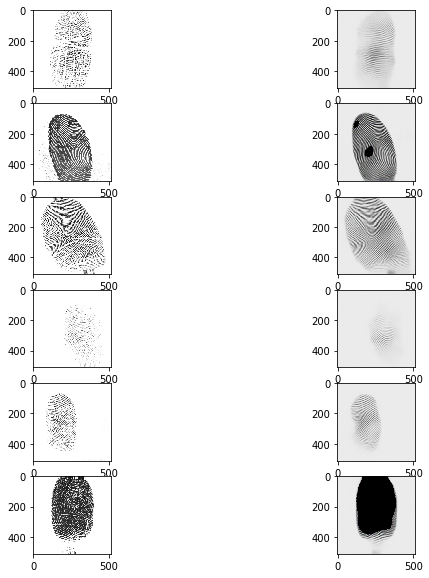

In [27]:
import matplotlib.pyplot as plt
i=1
plt.figure(figsize=(10, 10))
for n in N:
    plt.subplot(6,2,i)
    plt.imshow(img1[n])
    i= i+1
    plt.subplot(6,2,i)
    plt.imshow(img2[n])
    i=i+1

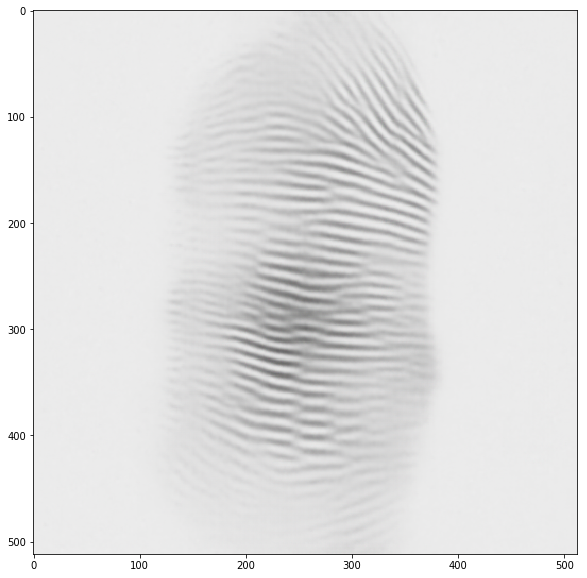

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(img2[0])